# CLRS: http://www.contres.com/ an Oil & Gas Company

In [5]:
from s3_tools.db import ForecastingDB,MasterDB,S3DB,DataentryDB,CuratedDB,RefreshingAuthS3FS
from IPython.display import display
import os
#os.chdir('/Users/ahmedghazaly/projects/core/')
os.chdir('/Users/ahmedghazaly/projects/basic_materials/')
import pandas as pd
os.environ['QAD_PORT'] = '1452'
os.environ['QAD_PASSWORD'] = 'dfQ4dD3vR34derR3d!'
os.environ['QAD_USER'] = 'df_qad_reader_dev'
from db_tools import databases, get_db
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
s3 = CuratedDB(env='qa', role='df_data_ingestion_nonprod')
s3_forecasting = ForecastingDB(env='qa', role='df_data_ingestion_nonprod')
import dflib.aws_auth

my_s3fs = dflib.aws_auth.get_client('s3')
bucket = s3.bucket
# database = s3.database

# contents = [obj.split('table=')[1] for obj in list((RefreshingAuthS3FS(anon=False).glob(
#             '{}/data/dynamic/db={}/'.format(bucket, database))))]
# datasets = [table for table in contents if table.startswith("comm")]

In [7]:
oilprice = s3.commodity_nymex_light_crude().set_index('timestamp')[['clc1']]
gasprice = s3.commodity_natural_gas().set_index('timestamp')
avg_oil_price = oilprice.resample('Q').mean()
avg_ngl_price = gasprice.resample('Q').mean()

In [8]:
price = pd.concat([avg_oil_price, avg_ngl_price], join='outer', axis=1)
price.columns = 'avg_oil_price','avg_gas_price'

In [9]:
estimates = pd.read_csv('estimatesoil2.csv')

In [10]:
e_gas_prod = estimates[(estimates.Measure == 336) & (estimates.IBESTicker == 'CLRS')].set_index('PerEndDate')[['DefMeanEst', 'NumEsts']]
e_oil_prod = estimates[(estimates.Measure == 338) & (estimates.IBESTicker == 'CLRS')].set_index('PerEndDate')[['DefMeanEst', 'NumEsts']]

In [11]:
eprod = pd.concat([e_gas_prod, e_oil_prod], join='outer', axis=1)[['DefMeanEst']]
eprod.columns = 'e_gas_prod', 'e_oil_prod'

In [12]:
data = pd.merge(eprod, price, how='inner', left_index=True, right_index=True)

In [13]:
data['oilRevenue'] = data.e_oil_prod * data.avg_oil_price / 1000
data['gasRevenue'] = data.e_gas_prod * data.avg_gas_price / 1000

In [14]:
data.head()

e_gas_prod   e_oil_prod  avg_oil_price  avg_gas_price  \
2014-09-30  30823.46000  11234.90000      97.249063       3.949484   
2014-12-31  32504.02500  12645.15000      73.196250       3.829219   
2015-03-31  32321.81250  12625.41250      48.574918       2.809230   
2015-06-30  34779.56250  13271.28571      57.812500       2.737078   
2015-09-30  40980.56667  13179.55556      46.498437       2.734656   

             oilRevenue  gasRevenue  
2014-09-30  1092.583492  121.736774  
2014-12-31   925.577561  124.465022  
2015-03-31   613.278377   90.799389  
2015-06-30   767.246205   95.194380  
2015-09-30   612.828740  112.067763

In [15]:
query = """
SELECT IBESTicker, PerEndDate, DefActValue, DefScale, UnitType from

(select estpermid permid, IBESTicker FROM qai.dbo.treinfo where IBESTicker IN ('CLRS')) a

join qai.dbo.TREActRpt b on a.permid = b.estpermid where Measure IN ('20') --GoldProd
AND PerEndDate > '2000' and PerType = '3' order by PerEndDate ASC

"""

qad = get_db(databases.qad)
revenue = qad.query_to_df(query).set_index('PerEndDate')

data = pd.merge(data, revenue[['DefActValue']], how='inner', left_index=True, 
                right_index=True).rename(columns ={'DefActValue': 'ActRev'})

Connecting to MS SQL database...


In [16]:
ibesRev = estimates[(estimates.Measure == 20) & (estimates.IBESTicker == 'CLRS')].set_index('PerEndDate')[['DefMeanEst']]
ibesRev.columns = ['IbesRev']

In [17]:
data = data.merge(ibesRev, how='inner', left_index=True, right_index=True)
data['CalcRev'] = data.oilRevenue + data.gasRevenue

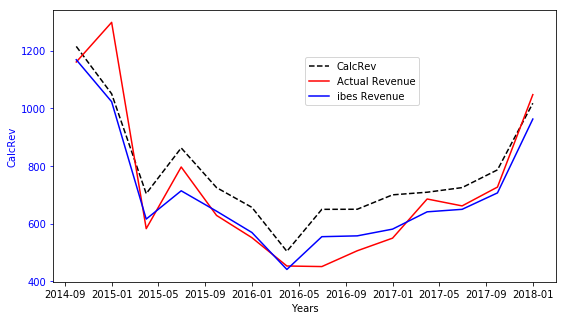

In [18]:
plt.rcParams["figure.figsize"] = (9,5)
fig, ax1 = plt.subplots()

ax1.plot(data.index, data.CalcRev, 'k--', label='CalcRev')
ax1.set_xlabel('Years')
ax1.set_ylabel('CalcRev', color='b')
ax1.tick_params('y', colors='b')
plt.legend(loc=(.5,.75))

ax1.plot(data.index, data.ActRev, 'r-', label='Actual Revenue')
plt.legend(loc=(.5,.65));

ax1.plot(data.index, data.IbesRev, 'b-', label='ibes Revenue')
plt.legend(loc=(.5,.65));

In [19]:
data.head()

e_gas_prod   e_oil_prod  avg_oil_price  avg_gas_price  \
2014-09-30  30823.46000  11234.90000      97.249063       3.949484   
2014-12-31  32504.02500  12645.15000      73.196250       3.829219   
2015-03-31  32321.81250  12625.41250      48.574918       2.809230   
2015-06-30  34779.56250  13271.28571      57.812500       2.737078   
2015-09-30  40980.56667  13179.55556      46.498437       2.734656   

             oilRevenue  gasRevenue    ActRev     IbesRev      CalcRev  
2014-09-30  1092.583492  121.736774  1160.281  1168.07822  1214.320266  
2014-12-31   925.577561  124.465022  1297.700  1022.68340  1050.042583  
2015-03-31   613.278377   90.799389   582.592   615.80890   704.077767  
2015-06-30   767.246205   95.194380   796.374   713.83214   862.440585  
2015-09-30   612.828740  112.067763   628.457   643.20886   724.896503

In [20]:
from scipy.optimize import curve_fit
import scipy
import numpy as np

def func(x, a, b, c):
    return a + b*x[0] + c*x[1]

x = scipy.array([data['oilRevenue'], data['gasRevenue']])
y = np.array(data.ActRev)

In [21]:
popt = curve_fit(func, x, y)
print('Estimated Coefficients = %s\n'%popt[0])

Estimated Coefficients = [-327.51968448    1.30673948    1.51348712]



In [22]:
def func(x, a, b, c):
    return a + b*x[4] + c*x[5]

data['ModelledRevenue'] = data.apply(lambda x: func(x, popt[0][0], popt[0][1], popt[0][2]), axis=1)

In [23]:
def computeModelledsurp(df):
    return round(((df.ActRev - df.ModelledRevenue)/(abs(df.ModelledRevenue))), 5)
data['ModelledSurp'] = data.apply(computeModelledsurp, axis=1)

In [24]:
def computeSurp(df):
    return round(((df.ActRev - df.CalcRev)/(abs(df.CalcRev))), 5)

In [25]:
data['ibesSurp'] = data.apply(computeSurp, axis=1)

In [26]:
print('Average ModelledSurp = %s'%(abs(data.ModelledSurp).mean()))
print('Average Ibes = %s'%(abs(data.ibesSurp).mean()))

Average ModelledSurp = 0.0842471428571
Average Ibes = 0.13504


In [27]:
plt.rcParams["figure.figsize"] = (9,5)
fig, ax1 = plt.subplots()

ax1.plot(data.index, data.ModelledSurp, 'k--', label='ModelledSurp')
ax1.set_xlabel('Years')
# # Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('CalcRev', color='b')
ax1.tick_params('y', colors='b')
plt.legend(loc=(.5,.75))

ax1.plot(data.index, data.ibesSurp, 'r-', label='ibesSurp')
plt.legend(loc=(.5,.65));